In [62]:
%matplotlib inline

goal:

an analysis with specific papers.
look at interdisciplinary papers, within discipline papers, and any
new post-hoc statistics that you think could be interesting.  for how
to do this, see our papers on collaborative topic modeling and my talk
about it (all on my website).  ask me if you are confused how to do
this.  i'm also interested in how this model fails on this data.  (we
know it must.)

a super thorough look at
this model would also consider the held out predictions and specific
users.  you would understand their interests via their clicks, and how
the model has captured or not captured them.

In [127]:
# replicate the functionality of explore-coll-msd-tm.R for posterity and general ease of use
import numpy as np
import cPickle as pickle
import pandas as pd
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt


#fitPath = "/scratch/shared/music_project/jaan/ctpf-fits/collabtm/src/nusers1128835-ndocs202994-nvocab256-k50-batch-bin-vb-fa-ldainit/"

# fit path
fitPath = '/scratch/shared/ctpf_fits/nusers120298-ndocs825708-nvocab14000-k163-batch-bin-vb-fa-ldainit-fdp/'

# output file
fName = '/home/waldorf/altosaar/projects/arxiv/fit/ctpf-summaries/arxiv-categories-ctpf.txt'

# maps
mapDir = '/scratch/shared/ctpf_fits/data_nusers120298-ndocs825708-nvocab14000-k163-batch-bin-vb-fa-ldainit-fdp/'
catFile = mapDir + 'cats.tsv'
id2itemFile = mapDir + 'items_arxiv_info.tsv'

In [41]:
categories = pd.read_csv(catFile, delimiter='\t',header=None, index_col=0, names=['category'])
id2item = pd.read_csv(id2itemFile, delimiter='\t', header=None, names=['arxiv_id', 'category', 'title', 'date'])
# important: 'items_arxiv_info.tsv' assumes non-zero indexing (i.e. theta's rows start from 1, not zero)
# so relabel for zero indexing!
id2item.index = id2item.index - 1

In [42]:
id2item[0:5]

,arxiv_id,category,title,date
0,1006.4053,quant-ph,Quantum entanglement between the electron clou...,2010-06-21
1,math/0411461,math.RT,"Geometric representations of GL(n,R), cellular...",2004-11-21
2,1102.0492,hep-ph,The Galactic Center Region Gamma Ray Excess fr...,2011-02-02
3,0804.3296,hep-ph,Strongly Interacting Gauge Mediation at the LHC,2008-04-21
4,cond-mat/9610209,cond-mat.stat-mech physics.bio-ph physics.chem...,A nonequilibrium equality for free energy diff...,1996-10-29


In [43]:
categories[0:5]

,category
0,quant-ph
1,math.RT
2,hep-ph
3,cond-mat.stat-mech
4,nucl-th


check that we have the right categories in the map:

In [44]:
print id2item[0:5].title[1]
print id2item[0:5].category[1]
print id2item[0:5].arxiv_id[1]

Geometric representations of GL(n,R), cellular Hecke algebras and the embedding problem
math.RT
math/0411461


from http://arxiv.org/abs/1006.4053 this is indeed in quant-ph

In [45]:
topic2category = categories.to_dict()['category']

In [46]:
# # load theta
# for fixed (observed) theta the code adds a small prior value (0.0308...) to each entry
# tName = fitPath + 'theta.tsv'
# # skip first two cols, and first row
# theta = pd.read_csv(tName, delimiter='\t', header=None).iloc[0:,2:]

# this is the fixed theta (according to arxiv category)
tName = fitPath + 'theta-lda-k163.tsv'
theta = pd.read_csv(tName, delimiter=' ', header=None)


theta = theta.as_matrix()
# normalize
# def normalizeRow(row):
#     return row / np.sum(row)
#theta.apply(normalizeRow, axis=0)

# num topics
k = len(theta[0])

# load epsilon
eName = fitPath + 'epsilon.tsv'

# skip first 2 cols
epsilon = pd.read_csv(eName, delimiter='\t', header=None).iloc[0:,2:]
epsilon = epsilon.as_matrix()

# load id2word
#mapName = '/scratch/shared/music_project/jaan/lda-fits/dat/id2word.pickle'
#id2word = pickle.load(open(mapName, 'rb'))

th_ep = theta + epsilon
th_ep_rs = np.sum(th_ep,axis=1)

id2item_dict = id2item.to_dict()

id2title = id2item_dict['title']
#id2title[0] = 'dummy title'
normth = theta

ERROR: first doc doesn't exist! from dave's R script comment. so replace its title in the dict.

In [47]:
theta[len(theta)-1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [48]:
id2title[len(theta)-1] = 'missing paper'

now we're ready to check if the observed topics match what's in our article id to title/arxiv id map. it checks out:

In [49]:
print topic2category[np.where(theta[3434] == 1)[0][0]]

print id2title[3434]

math.LO
Mathematical conceptualism


In [50]:
print th_ep.shape, th_ep_rs.shape

(825708, 163) (825708,)


In [51]:
# number of articles in category 0.
np.where(normth[:,0] > 0)[0].shape

(40367,)

In [52]:
#working
def similarArticles(docId, theta, n):
    sqrt_normed_theta = np.sqrt(normth[docId])
    a = np.sum(np.power(np.sqrt(normththeta) - sqrt_normed_theta,2),axis=1)
    # this was in reverse
    top = np.argsort(a)
    for topId in top[0:n]:
        print "%0.3f  %s" %(a[topId],id2title[topId])

#working
def topArticles(k,normth=normth,n=10):
    top = np.argsort(normth[:,k])[::-1]
    return ["%0.3f  %s" %(normth[topId,k],id2title[topId]) for topId in top[0:n]]
    #for topId in top[0:n]:
        #print "%0.3f  %s" %(normth[topId,k],id2title[topId]))
        
#working! mistake was that i added normalized theta to eps for th_ep.
def inFieldArticles(k,th_ep=th_ep,normth=normth,n=10,prop=0.15):
    ind = np.where(normth[:,k] > prop)
    th_ep_ind = th_ep[ind,k][0]
    top = np.argsort(th_ep_ind)[::-1]
    return ["%0.3f  %s" %(th_ep_ind[topId],id2title[ind[0][topId]]) for topId in top[0:n]]
    #for topId in top[0:n]:
     #   print "%0.3f  %s" %(th_ep_ind[topId],id2title[ind[0][topId]]) 
        
#working
def outFieldArticles(k, th_ep=th_ep, normth=normth, n=10, prop=0.05):
    ind = np.where(normth[:,k] < prop)
    th_ep_ind = th_ep[ind,k][0]
    top = np.argsort(th_ep_ind)[::-1]
    return ["%0.3f  %s" %(th_ep_ind[topId],id2title[ind[0][topId]]) for topId in top[0:n]]
    #for topId in top[0:n]:
     #   print "%0.3f  %s" %(th_ep_ind[topId],id2title[ind[0][topId]])

#working
def interFieldArticles(k, rs = th_ep_rs, th_ep = th_ep, n = 10, prop = 0.15):
    ind = np.where(normth[:,k] > prop)
    rs_ind = rs[ind]
    th_ep_ind = th_ep[ind,k][0]
    score = rs_ind - th_ep_ind
    top = np.argsort(score)[::-1]
    return ["%0.3f  %s" %(score[topId],id2title[ind[0][topId]]) for topId in top[0:n]]
    #for topId in top[0:n]:
    #    print "%0.3f  %s" %(score[topId],id2title[ind[0][topId]])

In [189]:
with open(fName, 'wb') as f:
    print>>f, 'this fit is in: ' + fitPath + '\n'
    #print>>f, 'the dataset is in: ' + datasetPath + '\n'
    for k in range(0,len(theta[0] + 1)):
        print>>f, '\n--------------------------------\n'
        print>>f, 'category k = ' + str(topic2category[k]) + '\n'
        print>>f, 'random articles from category'
        topArt = topArticles(k)
        for line in topArt:
            print>>f, line
        print>>f,'\nin-field articles'
        inField = inFieldArticles(k)
        for line in inField:
            print>>f,line
        print>>f,'\nout-field articles'
        outField = outFieldArticles(k)
        for line in outField:
            print>>f,line
        print>>f,'\ninter-field articles'
        interField = interFieldArticles(k)
        for line in interField:
            print>>f,line

look at hep articles that are of most interest to cond-mat

In [53]:
category2topic = {v:k for k, v in topic2category.items()}

In [54]:
category2topic

{nan: 75,
 'acc-phys': 158,
 'adap-org': 134,
 'alg-geom': 22,
 'ao-sci': 162,
 'astro-ph': 6,
 'astro-ph.CO': 14,
 'astro-ph.EP': 12,
 'astro-ph.GA': 19,
 'astro-ph.HE': 50,
 'astro-ph.IM': 55,
 'astro-ph.SR': 25,
 'atom-ph': 153,
 'bayes-an': 157,
 'chao-dyn': 70,
 'chem-ph': 154,
 'cmp-lg': 125,
 'comp-gas': 152,
 'cond-mat': 54,
 'cond-mat.dis-nn': 62,
 'cond-mat.mes-hall': 16,
 'cond-mat.mtrl-sci': 40,
 'cond-mat.other': 29,
 'cond-mat.quant-gas': 23,
 'cond-mat.soft': 33,
 'cond-mat.stat-mech': 3,
 'cond-mat.str-el': 7,
 'cond-mat.supr-con': 8,
 'cs.AI': 117,
 'cs.AR': 127,
 'cs.CC': 49,
 'cs.CE': 139,
 'cs.CG': 81,
 'cs.CL': 126,
 'cs.CR': 72,
 'cs.CV': 135,
 'cs.CY': 109,
 'cs.DB': 110,
 'cs.DC': 89,
 'cs.DL': 102,
 'cs.DM': 95,
 'cs.DS': 65,
 'cs.ET': 156,
 'cs.FL': 94,
 'cs.GL': 155,
 'cs.GR': 130,
 'cs.GT': 105,
 'cs.HC': 140,
 'cs.IR': 27,
 'cs.IT': 35,
 'cs.LG': 87,
 'cs.LO': 88,
 'cs.MA': 119,
 'cs.MM': 76,
 'cs.MS': 144,
 'cs.NA': 121,
 'cs.NE': 59,
 'cs.NI': 73,
 'cs.OH

try to look at papers in hep that are popular in cond-mat

In [55]:
def betweenFieldArticles(k1, k2, normth = normth, ep = epsilon, n = 10, prop = 0.15):
    # article indices in topic k1
    ind = np.where(normth[:,k1] > prop)
    
    # popularity of articles in k1 in topic k2
    ep_ind = ep[ind,k2][0]
    
    # most popular articles with respect to k2 that are in k1
    top = np.argsort(ep_ind)[::-1]
    return ["%0.3f  %s" %(top[topId],id2title[ind[0][topId]]) for topId in top[0:n]]

betweenField = betweenFieldArticles(category2topic['hep-ph'], category2topic['cond-mat'])
for line in betweenField:
    print line

73000.000  $S_3$ as a unified family theory for quarks and leptons
29004.000  Baryon Number Violating Transitions in String Backgrounds
75427.000  Heavy Quark Productions with Spin
49901.000  Effective operators in top physics
568.000  Proton spin polarizabilities from polarized Compton scattering
45106.000  Strong WW scattering in unitary gauge
74212.000  Physics Motivations for a Muon Collider
10950.000  Effective String Rope Model for the initial stages of Ultra-Relativistic Heavy Ion Collisions
14672.000  Correlations and fluctuations - Introduction
25403.000  Phenomenological approach to symmetry breaking pattern of democratic mass matrix


In [26]:
id2item.sort(columns='date', ascending=False)

,arxiv_id,category,title,date
15444,1212.6238,cond-mat.str-el,Soft lattice dynamics from broken electronic s...,2012-12-26
17698,1212.6152,math.NT,Modular parametrizations of certain elliptic c...,2012-12-26
29611,1212.6132,cond-mat.str-el cond-mat.mtrl-sci,Epitaxial strain induced magnetic transitions ...,2012-12-26
30105,1212.6163,quant-ph cond-mat.stat-mech,Computing complexity measures for quantum stat...,2012-12-26
33290,1212.6153,astro-ph.CO hep-ex nucl-ex physics.ins-det,"Search for solar axions in XMASS, a large liqu...",2012-12-26
34462,1212.6131,astro-ph.HE nucl-th,Numerical modeling of core-collapse supernovae...,2012-12-26
38489,1212.6154,hep-ph astro-ph.CO,Neutrino mass from Cosmology,2012-12-26
42792,1212.6158,astro-ph.CO,Diffuse light in the young cluster of galaxies...,2012-12-26
53697,1212.6237,astro-ph.IM,NICHE: The Non-Imaging CHErenkov Array,2012-12-26
66576,1212.6225,cs.IT math.IT,Joint Sensing and Power Allocation in Nonconve...,2012-12-26


check how many are NaN's 

In [184]:
len(id2item[id2item.date.isnull()])

98

In [185]:
len(id2item[id2item.category.isnull()])

19568

In [188]:
len(id2item)

825707

look up stephan's paper

In [56]:
id2item[id2item.arxiv_id == '1008.0468']

,arxiv_id,category,title,date
591359,1008.0468,cond-mat.quant-gas,Equilibration rates and negative absolute temp...,2010-08-03


In [20]:
epsilon_categories = pd.DataFrame(data=epsilon, columns=list(categories.category))

In [50]:
np.where(theta[591359] > 0)

(array([23]),)

In [51]:
topic2category[23]

'cond-mat.quant-gas'

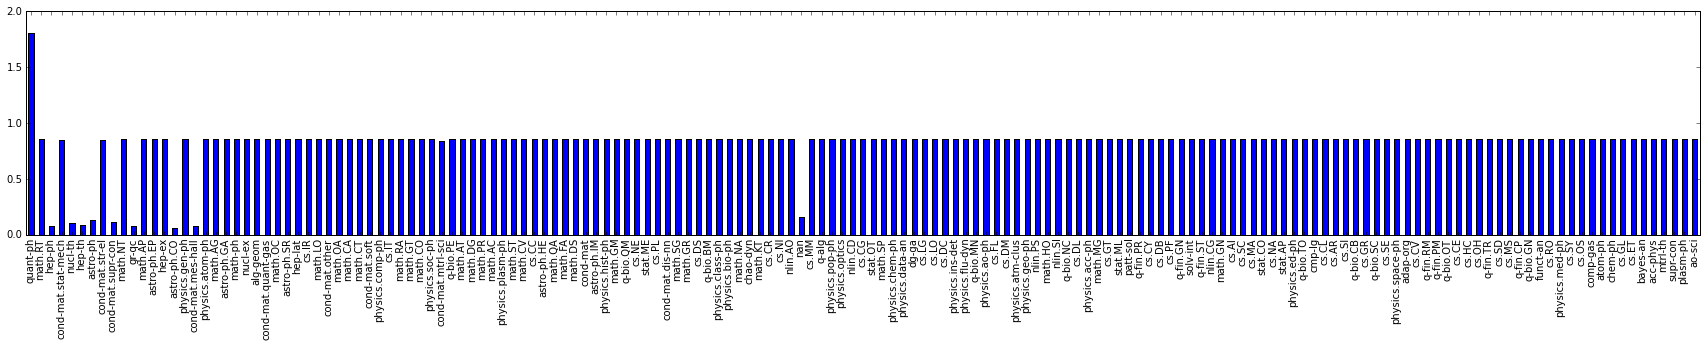

In [48]:
epsilon_categories.loc[591359].plot(kind='bar', figsize=(30, 4))

look at sachdev / ads cft

In [52]:
id2item[id2item.arxiv_id == '1002.2947']

,arxiv_id,category,title,date
32144,1002.2947,hep-th cond-mat.str-el,Condensed matter and AdS/CFT,2010-02-16


In [56]:
np.where(theta[32144]>0)

topic2category[5]

epsilon_categories.loc[32144].plot(kind='bar', figsize=(30, 4))

(array([5]),)

look at altland & zirnbauer

In [58]:
id2item[id2item.arxiv_id == 'cond-mat/9602137']

,arxiv_id,category,title,date
247629,cond-mat/9602137,cond-mat,Novel Symmetry Classes in Mesoscopic Normal-Su...,1996-02-27


In [57]:
def plot_eps(doc_id):
    
    print id2title[doc_id]
    
    topic = np.where(theta[doc_id]>0)[0][0]

    print topic2category[topic]

    epsilon_categories.loc[doc_id].plot(kind='bar', figsize=(30, 4))

* nb: epsilon can't be strictly zero because the likelihood could be zero, but there is a positive prior contribution too.

In [58]:
epsilon[247629]

array([ 0.0591901 ,  0.85750325,  0.08083917,  0.84411919,  9.49998022,
        0.08501274,  0.95745932,  0.85217078,  0.60492543,  0.85776876,
        0.07862758,  0.85685652,  0.85769033,  0.85787091,  0.28568563,
        0.85740961,  0.07944102,  0.85716955,  0.85758356,  0.85781527,
        0.85632469,  0.857534  ,  0.85752204,  0.85768421,  0.85764943,
        0.85747465,  0.8574717 ,  0.85748262,  0.8575981 ,  0.85770173,
        0.85767245,  0.85770564,  0.85750899,  0.85448301,  0.85753535,
        0.85785411,  0.85760347,  0.85776568,  0.85782704,  0.85766577,
        0.8355029 ,  0.85750113,  0.8576487 ,  0.85719773,  0.85775171,
        0.85763936,  0.85760589,  0.85749363,  0.85760537,  0.85741052,
        0.85789641,  0.85751369,  0.85777557,  0.85778808,  0.85305726,
        0.85760712,  0.85749643,  0.8575292 ,  0.85749543,  0.85748288,
        0.85755395,  0.85749106,  0.85708622,  0.85757642,  0.85743041,
        0.85761437,  0.85750027,  0.85750926,  0.85758228,  0.85

Novel Symmetry Classes in Mesoscopic Normal-Superconducting Hybrid Structures
cond-mat


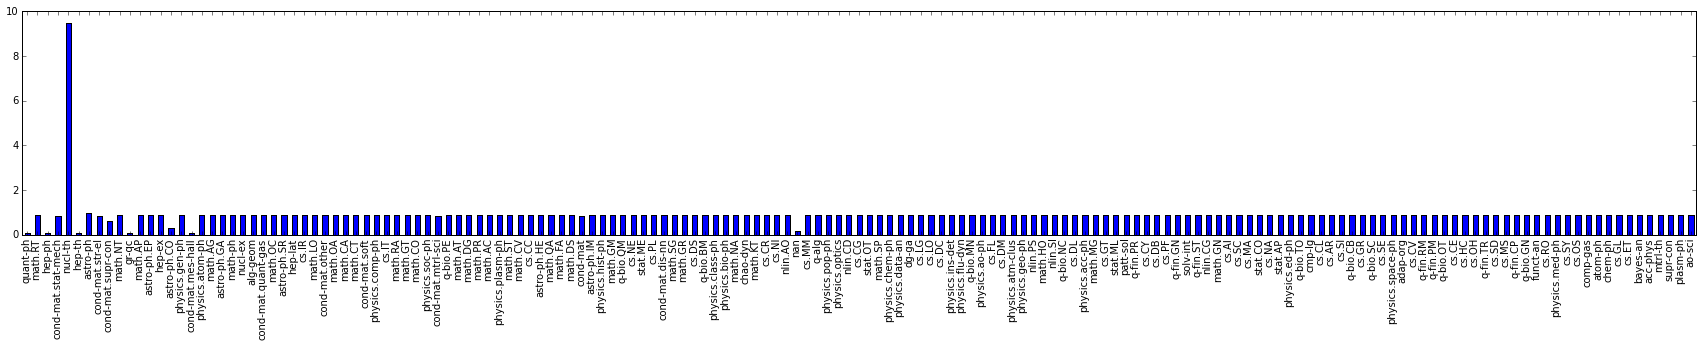

In [27]:
plot_eps(247629)

* we expect this to be cited in condensed matter & mathematics. it doesn't make sense that it's popular in nucl-th (nuclear theory). checking on web of science, we see that out of 500+ citations there is only one paper citing it in nuclear physics: http://i.imgur.com/YHjoqFa.png 

* this actually might make sense. zirnbauer was a former nuclear theorist so this 'anomalous' interest might be from his old community.

* the lower epsilons could be coming from the fact that in these categories (e.g. cond-mat.meso) these interests are explained by the category/user interests in that category, so epsilon only captures anomalies (nucl-th, due to his former associations)

* rename epsilon as 'anomalous popularity'? so small epsilon == very normal, we expect it to be popular in these categories!

* it's bad that epsilon is never negative, because it *should* be negative for popularity for most articles, for most topics (e.g. a differential geometry person will never be interested in a high energy physics experimental paper)

* it's bad that the largest epsilons have low citations (b.c. of anomalous interpretation). e.g. assume a paper has 10 citations, all of them are from atypical fields not expected to city this paper. for those users, the preferences are small, ~10^-3. to predict the rate of 10, the corresponding epsilon pois parameter needs to be inversely proportional to this v. small no (e.g. 10^4 s.t. 10^4 * 10^-3 = 10).

* test this: x_u dot eps_k is of same order as number of clicks for that user-item pair (which is 0 or 1). consider only users that clicked on this article, for these users compute mean preference of this category. then epsilon * 

* try to back up this 'anomalous' behaviour by estimating the number of citations we'd expect.

try to look at most 'popular' papers in condensed matter (epsilon should correspond to clicks?)

In [29]:
top = epsilon_categories.sort(columns='cond-mat', ascending=False)['cond-mat']

In [24]:
top = top[0:10]

In [25]:
for ID, eps in zip(top.index, top):
    print id2title[ID], ID, eps

A Heawood-type result for the algebraic connectivity of graphs on surfaces 643098 34.04723535
Elliptic mod \ell Galois representations which are not minimally elliptic 571709 26.42897866
T-adic exponential sums under diagonal base change 357541 23.95688177
On the Ruin Probability of the Generalised Ornstein-Uhlenbeck Process in the Cram\'er Case 295394 22.08663647
A substellar component orbiting the F-star 30 Ari B 612299 20.7947499
Interplay of chemotaxis and chemokinesis mechanisms in bacterial dynamics 510582 20.7903199
Influence of Charge and Energy Imbalances on the Tunneling Current through a Superconductor-Normal Metal Junction 343026 20.51177655
Mass spectrum of primordial black holes from inflationary perturbation in the Randall-Sundrum braneworld: a limit on blue spectra 268873 20.27291712
Becoming classical: A possible influence on the quantum-to-classical transition 140015 18.0145648
$S_3$ as a unified family theory for quarks and leptons 326540 17.64273735


A Heawood-type result for the algebraic connectivity of graphs on surfaces
math.CO


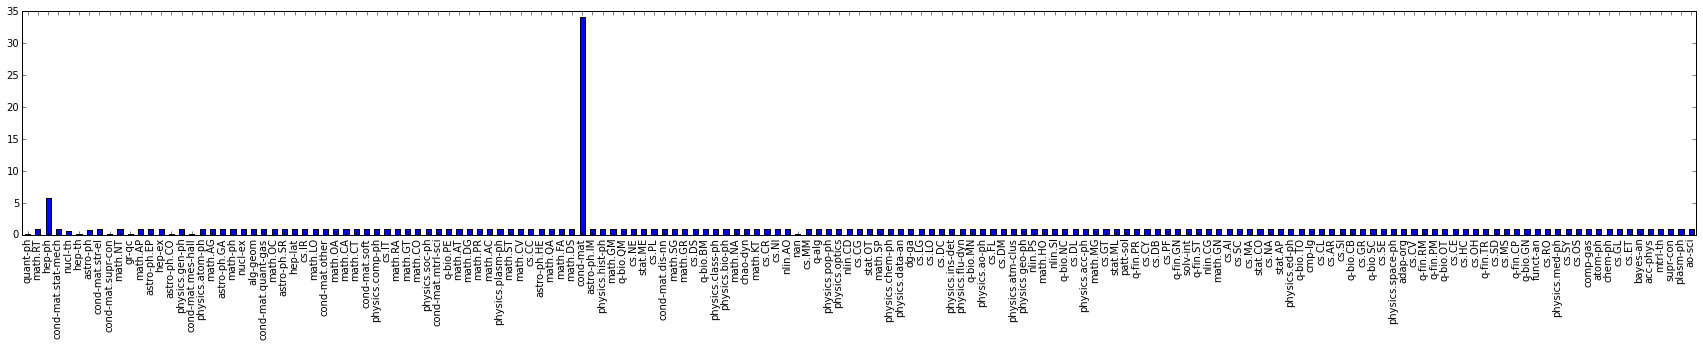

In [70]:
plot_eps(643098)

this is an article that attracts people in condensed matter and unusually so

Elliptic mod \ell Galois representations which are not minimally elliptic
math.NT


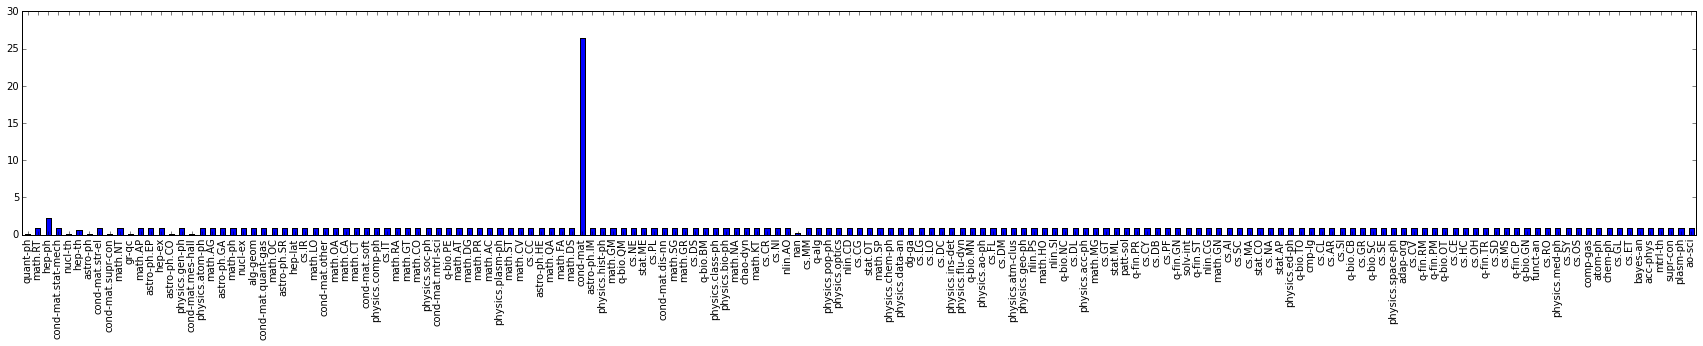

In [71]:
plot_eps(571709)

On the Euclidean Version of the Photon Number Integral
math-ph


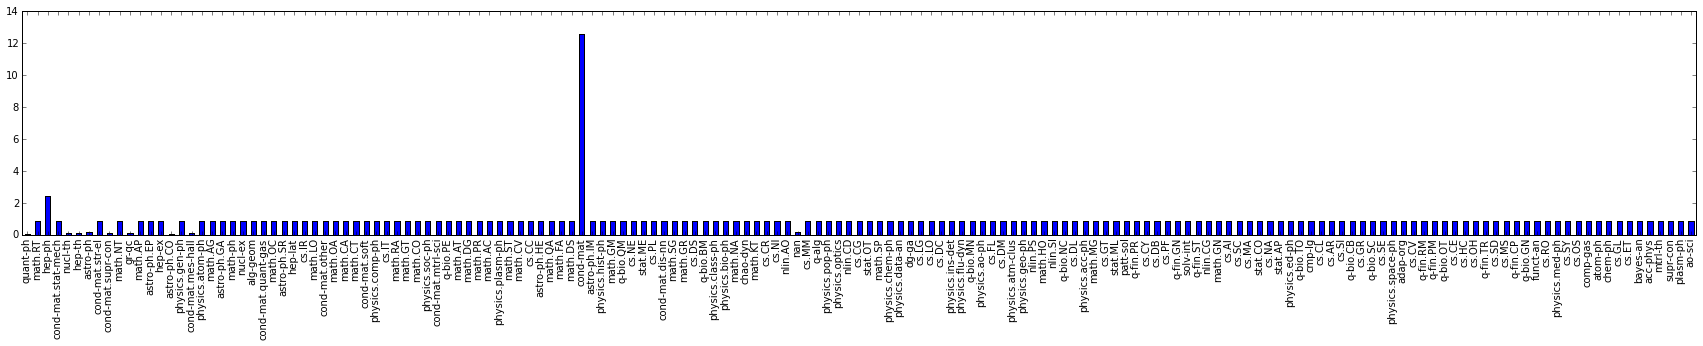

In [72]:
plot_eps(229777)

look at norm of epsilon to see if it correlates to popularity

In [32]:
epsilon_norm = np.sqrt(np.square(epsilon_categories).sum(axis=1))

In [34]:
epsilon_norm.sort(ascending=False)

In [38]:
for ID, eps in zip(epsilon_norm[0:10].index, epsilon_norm[0:10]):
    print ID, eps, id2title[ID]

2275 764.251625552 Chiral Symmetry Breaking and Pions in Non-Supersymmetric Gauge/Gravity Duals
23499 658.927576415 Title Stripes in Microscopic Theory of High-Tc Superconductivity
10847 547.698928183 High temperature ferromagnetism in GdFe2Zn20: large, local moments embedded in the nearly ferromagnetic Fermi liquid compound YFe2Zn20
4999 503.566578676 What galaxies know about their nearest cluster
3027 413.005889891 Josephson vortex dynamic in superconducting $YBa_2Cu_3O_x$ ceramics
1988 409.864579396 Quantum renormalization group approach to geometric phases in spin chains
14998 390.856759274 Field dependence of the Eu2+ spin relaxation in EuFe(2-x)CoxAs2
10889 378.178038579 From gas to satellitesimals: disk formation and evolution
1247 376.280097768 Linear Systems on Tropical Curves
2110 363.812001573 NMR experiment factors numbers with Gauss sums


the proof of innocence is one of the most popular articles on the arxiv in terms of clicks (major press coverage, etc)

In [60]:
id2item[id2item.arxiv_id == '1204.0162']

,arxiv_id,category,title,date
13071,1204.0162,physics.pop-ph physics.data-an,The Proof of Innocence,2012-04-01


The Proof of Innocence
physics.pop-ph


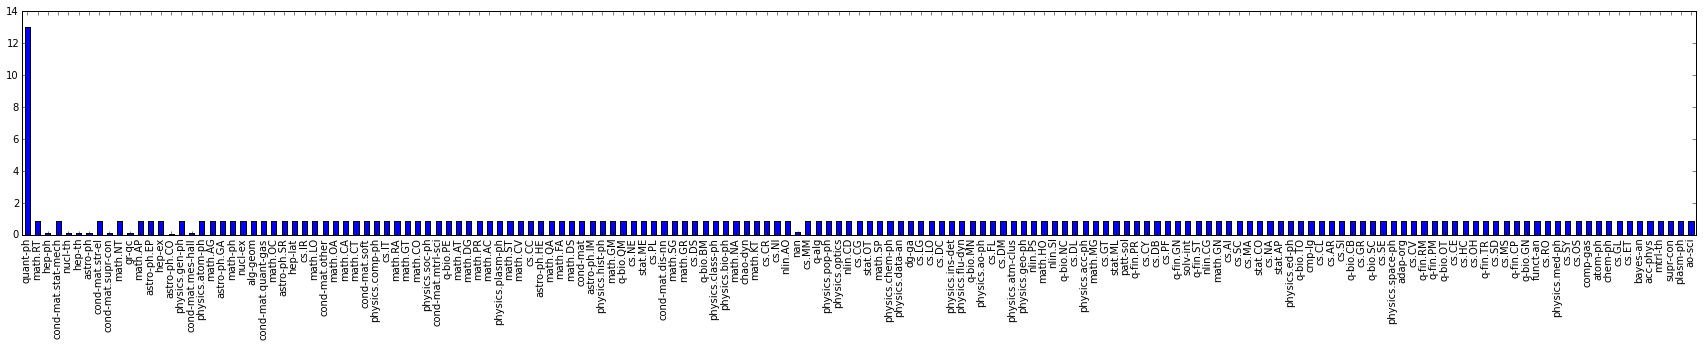

In [61]:
plot_eps(13071)

look at some highly-cited papers (via https://www.quora.com/What-are-some-of-the-most-cited-papers-from-arXiv)

one of the most cited papers in physics: 9711200

In [66]:
id2item[id2item.arxiv_id == 'hep-th/9711200']

,arxiv_id,category,title,date
8182,hep-th/9711200,hep-th,The Large N Limit of Superconformal Field Theo...,1997-11-27


The Large N Limit of Superconformal Field Theories and Supergravity
hep-th


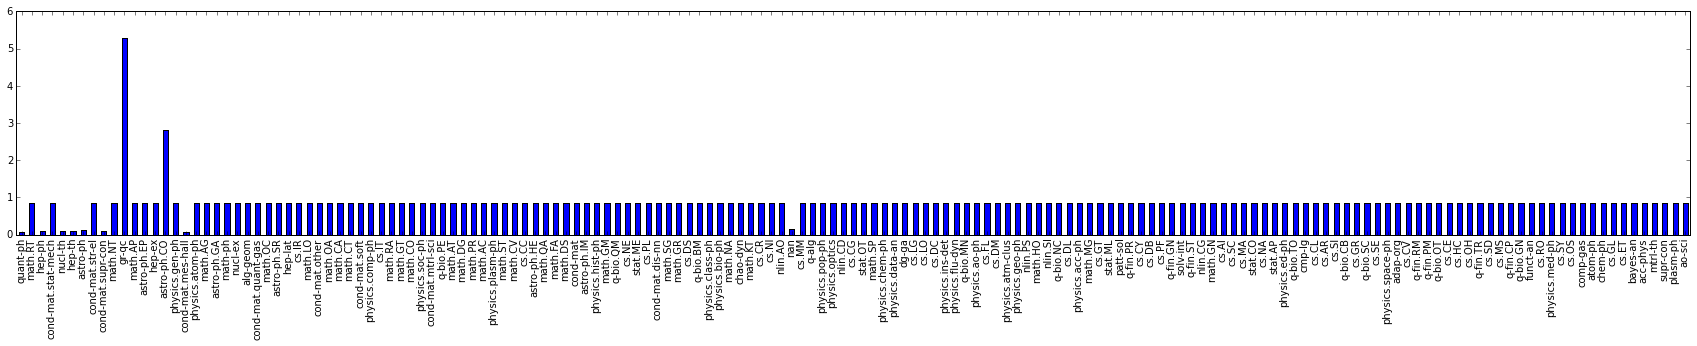

In [67]:
plot_eps(8182)

as we can see, it's the same story: anomalous interest is captured in epsilon. we expect hep-th, quant-ph, etc (the categories with lowered epsilons) to show interest. however, general relativity and non-galactic astrophysics showed more interest in this article than was captured by the user preferences.

In [145]:
lst = ['astro-ph/9812133', 'astro-ph/9805201', 'astro-ph/0302209']

In [153]:
idlist = []
for idx in range(0,len(lst)):
    idlist.append(id2item[id2item.arxiv_id == lst[idx]].index[0])

In [154]:
idlist

[5069, 15868, 104]

Measurements of Omega and Lambda from 42 High-Redshift Supernovae
astro-ph


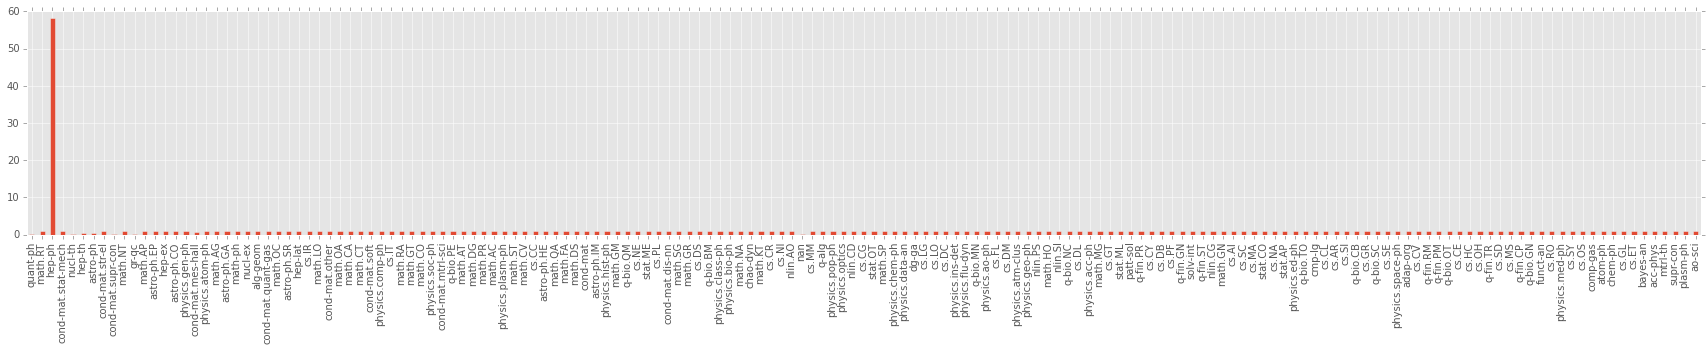

Observational Evidence from Supernovae for an Accelerating Universe and a Cosmological Constant
astro-ph


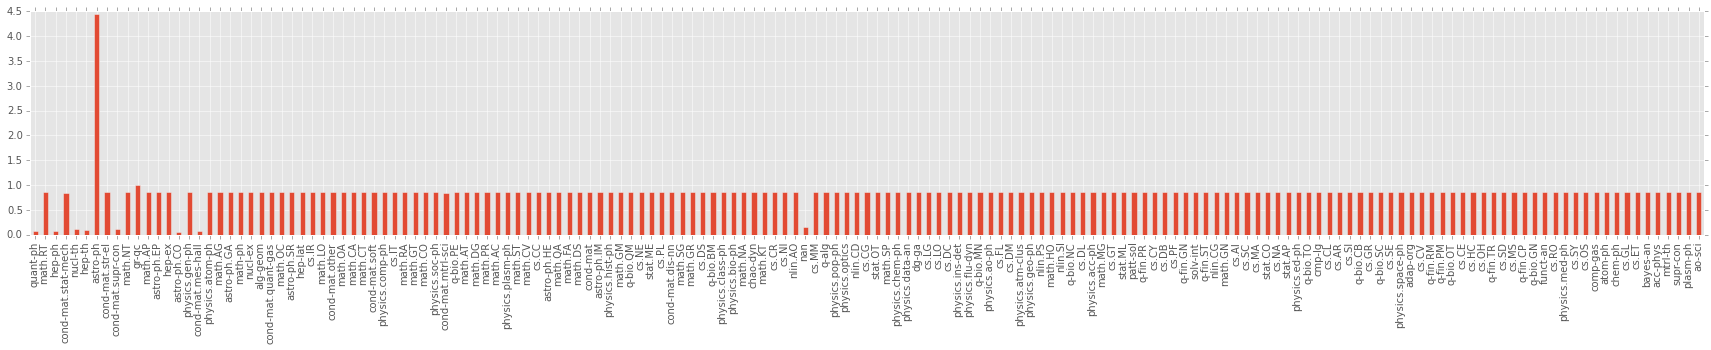

First Year Wilkinson Microwave Anisotropy Probe (WMAP) Observations: Determination of Cosmological Parameters
astro-ph


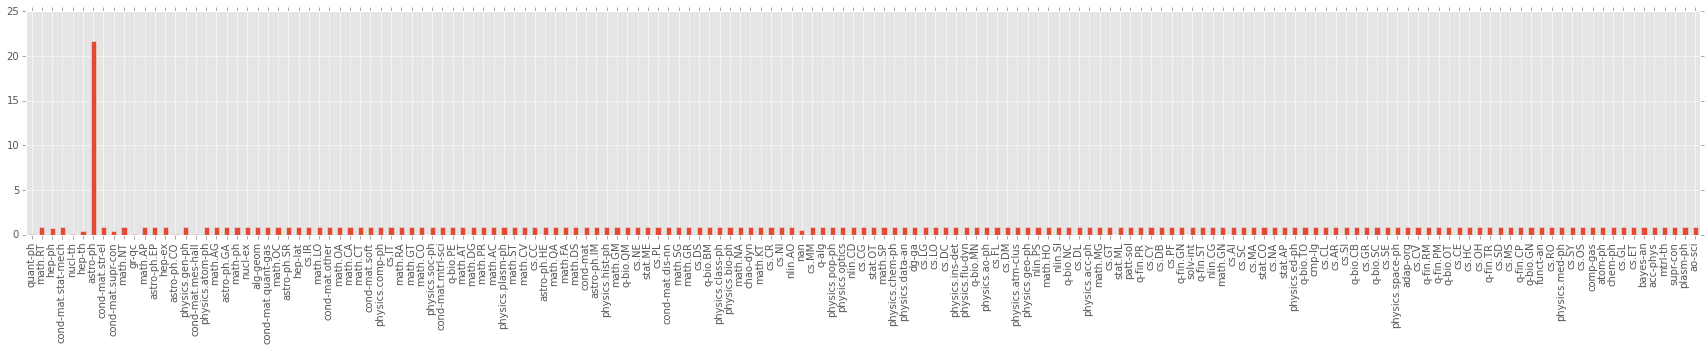

In [156]:
for idx in idlist:
    plot_eps(idx)
    plt.show()
    plt.close()

look at histogram for papers in categories

In [74]:
theta_categories = pd.DataFrame(data=theta, columns=list(categories.category))

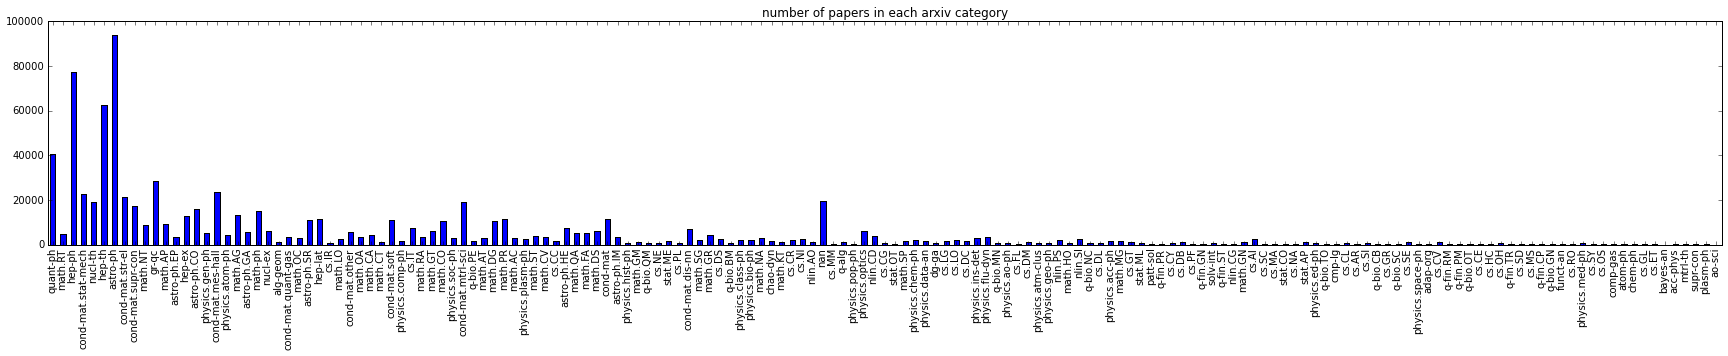

In [82]:
theta_categories.sum().plot(kind='bar',figsize=(30, 4), title='number of papers in each arxiv category')

which categories have the most 'surprise'? i.e., the highest average theta?

In [86]:
epsilon_describe = epsilon_categories.describe()

In [87]:
epsilon_describe

,quant-ph,math.RT,hep-ph,cond-mat.stat-mech,nucl-th,hep-th,astro-ph,cond-mat.str-el,cond-mat.supr-con,math.NT,...,atom-ph,chem-ph,cs.GL,cs.ET,bayes-an,acc-phys,mtrl-th,supr-con,plasm-ph,ao-sci
count,825708.000000,825708.000000,825708.000000,825708.000000,825708.000000,825708.000000,825708.000000,825708.000000,825708.000000,825708.000000,...,825708.000000,825708.000000,825708.000000,825708.000000,825708.000000,825708.000000,825708.000000,825708.000000,825708.000000,825708.000000
mean,1.155409,0.857416,1.207115,0.858846,0.950326,1.145021,1.082241,0.858700,0.943953,0.857702,...,0.857055,0.857059,0.857053,0.857054,0.857051,0.857053,0.857061,0.857055,0.857052,0.857051
std,3.861843,0.031767,4.351450,0.231011,3.957862,5.270111,3.215250,0.177824,3.369816,0.030169,...,0.001041,0.001041,0.001041,0.001041,0.001041,0.001041,0.001041,0.001041,0.001041,0.001041
min,0.058851,0.856624,0.079865,0.843269,0.099957,0.080342,0.127017,0.851310,0.097830,0.856892,...,0.856556,0.856560,0.856554,0.856555,0.856552,0.856554,0.856563,0.856556,0.856553,0.856552
25%,0.058853,0.856757,0.079875,0.843397,0.100032,0.080352,0.127266,0.851441,0.097841,0.857025,...,0.856690,0.856694,0.856688,0.856689,0.856685,0.856688,0.856696,0.856690,0.856687,0.856685
50%,0.058954,0.856872,0.080167,0.843509,0.100812,0.080770,0.129094,0.851553,0.098501,0.857139,...,0.856805,0.856809,0.856803,0.856804,0.856801,0.856803,0.856811,0.856805,0.856802,0.856801
75%,0.061491,0.857127,0.093865,0.843760,0.107373,0.085991,0.234699,0.851805,0.119720,0.857393,...,0.857060,0.857063,0.857058,0.857059,0.857055,0.857058,0.857066,0.857060,0.857056,0.857055
max,269.839143,11.890348,362.023013,34.287658,290.216772,508.736935,334.555587,25.688108,219.123434,6.456309,...,0.910412,0.910413,0.910411,0.910411,0.910409,0.910411,0.910415,0.910412,0.910410,0.910409


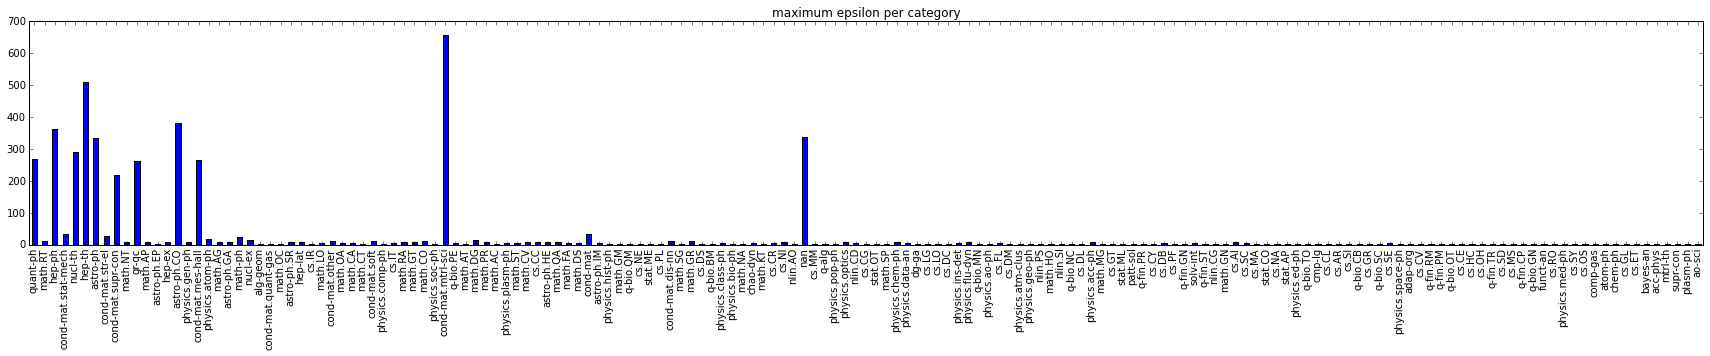

In [98]:
epsilon_describe.iloc[7,:].plot(kind='bar', figsize=(30, 4), title='maximum epsilon per category')

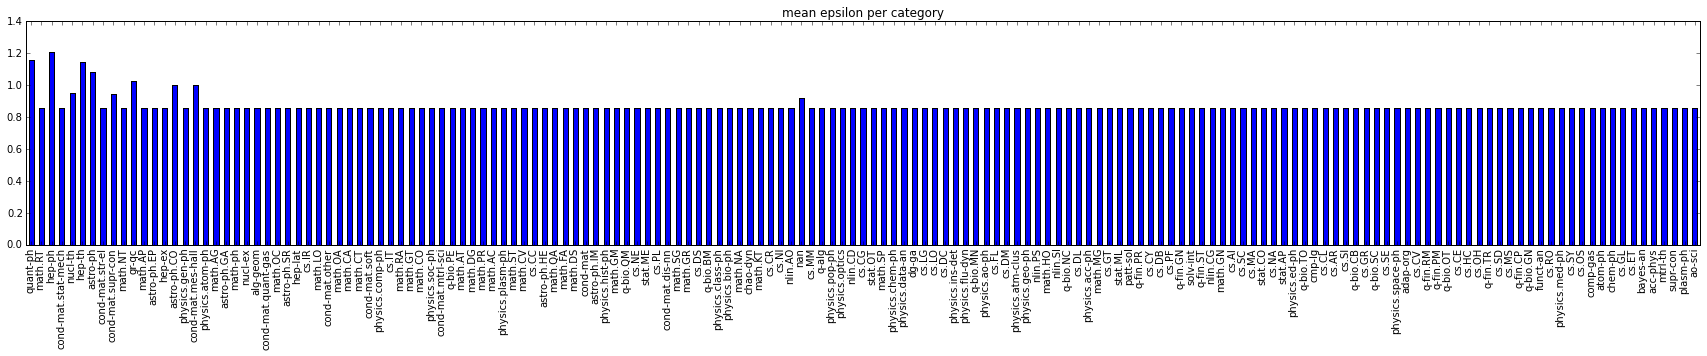

In [101]:
epsilon_describe.iloc[1,:].plot(kind='bar', figsize=(30, 4), title='mean epsilon per category')

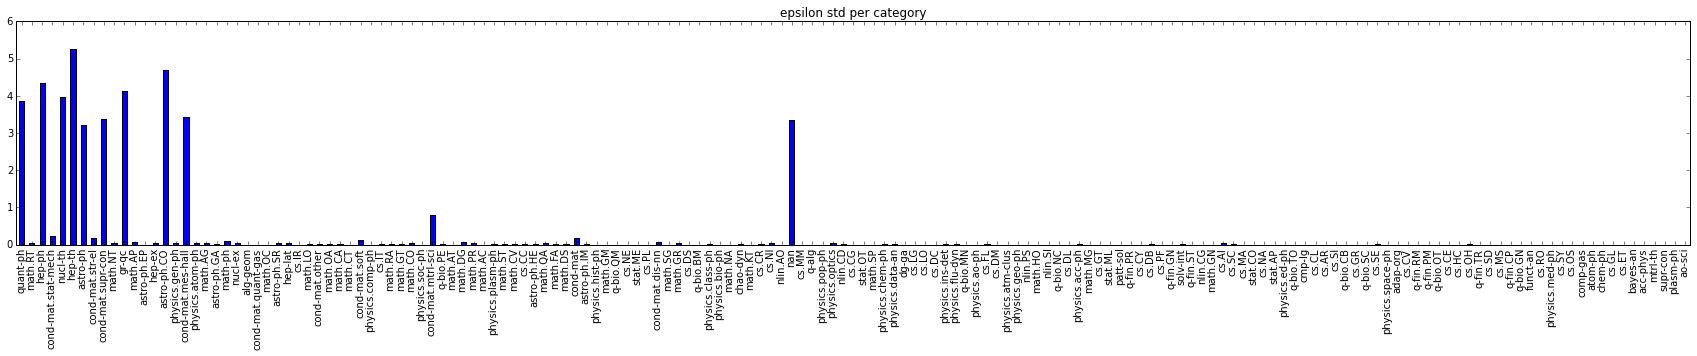

In [102]:
epsilon_describe.iloc[2,:].plot(kind='bar', figsize=(30, 4), title='epsilon std per category')

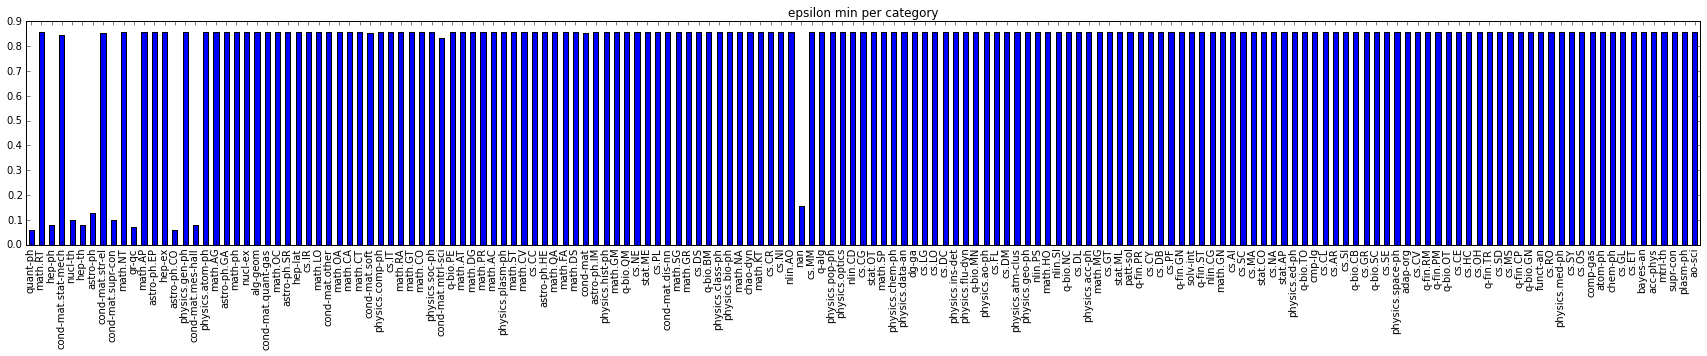

In [103]:
epsilon_describe.iloc[3,:].plot(kind='bar', figsize=(30, 4), title='epsilon min per category')

plot epsilon min and number of papers per category

In [105]:
eps_min = epsilon_describe.iloc[3,:]

In [106]:
num_articles_per_category = theta_categories.sum()

In [114]:
eps_min_and_num = pd.concat([eps_min, num_articles_per_category], axis=1).T

In [115]:
eps_min_and_num.index = ['min', 'num_articles']

In [ ]:
id2item

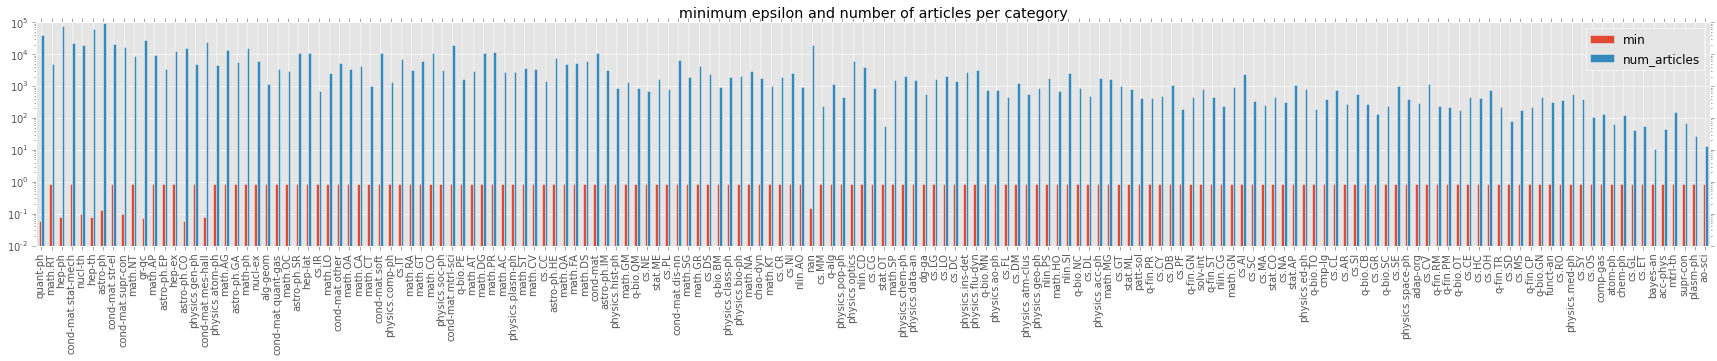

In [144]:
eps_min_and_num.T.plot(kind='bar', figsize=(30, 4), title='minimum epsilon and number of articles per category', logy=True)